### Transform each iterm-self(string) to one vector in which every component is tfidf value
#### Original: TP of METHODS FOR BIG DATA ANALYTICS
#### Xiyu ZHANG on Wed Nov 23 00:22:55 CET 2016  

In [1]:
import pandas as pd
data=pd.read_csv('./Movie_Summary_20161122_final.csv', encoding="utf-8")
# data.head()

In [2]:
import nltk
from nltk.stem.porter import *
import string
# nltk.download()
# print nltk.corpus.stopwords.words('english')
# For each document in the dataset, do the preprocessing
def preprocess(text):
    # Remove punctuation, stopword and then stemmering
    punctuation = set(string.punctuation)
    stemmer = PorterStemmer()
    doc = [stemmer.stem(i) for i in nltk.word_tokenize(text) if (i not in punctuation) and (i not in nltk.corpus.stopwords.words('english'))]
    # Covenrt list of words to one string
    doc = ' '.join(w for w in doc)
    return doc
# data["Summary"] = data["Summary"].apply(preprocess)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# Construct the Document−Term TF−IDF matrix
m = TfidfVectorizer()
tfidf_matrix = m.fit_transform(data["Summary"])
tfidf_matrix = tfidf_matrix.toarray() # convert to numpy array
# Examine the size and the sparsity of the tfidf_matrix
print tfidf_matrix.shape
print float(np.count_nonzero(tfidf_matrix)) / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])

(34153, 128172)
0.00125605810566


In [4]:
from sklearn.model_selection import train_test_split
labels = data.drop({"Summary", "Unnamed: 0"}, axis=1).as_matrix()
X = tfidf_matrix[0:200]
y = labels[0:200]
# Split the data into random train and test subsets. Here we use 40% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print "X_train.shape:", X_train.shape
print "y_train.shape:", y_train.shape

X_train.shape: (120, 128172)
y_train.shape: (120, 16)


In [5]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
n_classes = y.shape[1]
# Learn to predict each class against the other
clf_svm = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score_svm = clf_svm.fit(X_train, y_train).predict_proba(X_test)
clf_rf  = OneVsRestClassifier(RandomForestClassifier(n_estimators=70, max_depth=70))
y_score_rf = clf_rf.fit(X_train, y_train).predict_proba(X_test)

In [6]:
def draw_ROC(y_real_and_y_pedit_and_clf_name_list):
    """ y_test_and_y_score: une liste de y_test et y_score.
        [(y_test, y_score, name), (y_test, y_score, name),...]
        y_test est label réal
        y_score est label prédit 
        name est le nom de classification
       """
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    # Plot all ROC curves
    plt.figure()
    for y_test, y_score, name in y_real_and_y_pedit_and_clf_name_list:
        n_classes = y_score.shape[1]
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        # Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["micro"], tpr["micro"],
                 label = name + ' micro ROC (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),  linewidth=2)
        plt.plot(fpr["macro"], tpr["macro"],
                 label = name + ' macro ROC (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),  linewidth=2)

        #for i in range(n_classes):
        #    plt.plot(fpr[i], tpr[i], lw=2,
        #    label='ROC curve of {0} (area = {1:0.2f})'
        #             ''.format(data.columns.values[i+2], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-labels')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

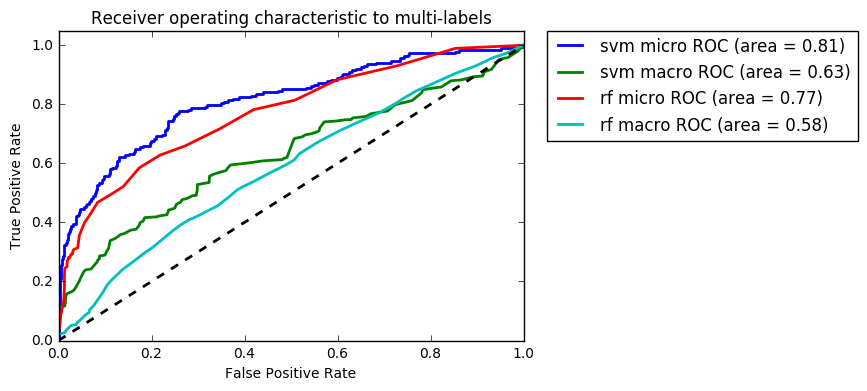

In [7]:
draw_ROC([ (y_test, y_score_svm, "svm"), (y_test, y_score_rf, "rf")])